### 1. unable 로 추가된 time 을 추가 및 재배열에 활용하기
- 1-1. intubationtime, intubationtime(un), extubationtime, extubationtime(un)이 포함된 테이블 읽기
- 1-2. intubation-extubation 은 pairing 되어야 하므로 연속해서 intubation event가 있거나 연속해서 extubation event 가 있으면 에러로 볼 수 있음.
- 1-3. error 타입 정의하고 해결
- 1-4. pairing 및 seq 부여

#### 1-1. intubationtime, intubationtime_un, extubationtime, extubationtime_un 이 포함된 테이블 읽기

In [1]:
import pandas as pd
from dfply import *
import time
from tqdm import tqdm
import warnings

# CSV 파일 읽기, 날짜 컬럼 자동 파싱
unable_intu_extu = pd.read_csv('./data/unable_intu_extu.csv', 
                               encoding='utf-8-sig',
                               parse_dates=['intubationtime(un)', 'extubationtime(un)'])

print("Data loaded successfully. Shape:", unable_intu_extu.shape)
print("\nFirst few rows:")
print(unable_intu_extu.head())

Data loaded successfully. Shape: (17640, 13)

First few rows:
   subject_id   hadm_id   stay_id gender        los            admittime  \
0    10001884  26184834  37510196      F   9.171817  2131-01-07 20:39:00   
1    10001884  26184834  37510196      F   9.171817  2131-01-07 20:39:00   
2    10001884  26184834  37510196      F   9.171817  2131-01-07 20:39:00   
3    10001884  26184834  37510196      F   9.171817  2131-01-07 20:39:00   
4    10003400  23559586  38383343      F  16.069838  2137-08-04 00:07:00   

   intubationtime(un)  extubationtime(un)  intu_extu_duration(period)  \
0 2131-01-11 08:00:00 2131-01-12 17:30:00                   33.500000   
1 2131-01-13 04:00:00 2131-01-13 20:00:00                   16.000000   
2 2131-01-14 08:08:00 2131-01-17 20:09:00                   84.016667   
3 2131-01-19 00:00:00 2131-01-19 08:00:00                    8.000000   
4 2137-08-18 02:00:00 2137-08-21 16:00:00                   86.000000   

   to_reintubation(un)  unableseq         

<Figure size 2000x1000 with 0 Axes>

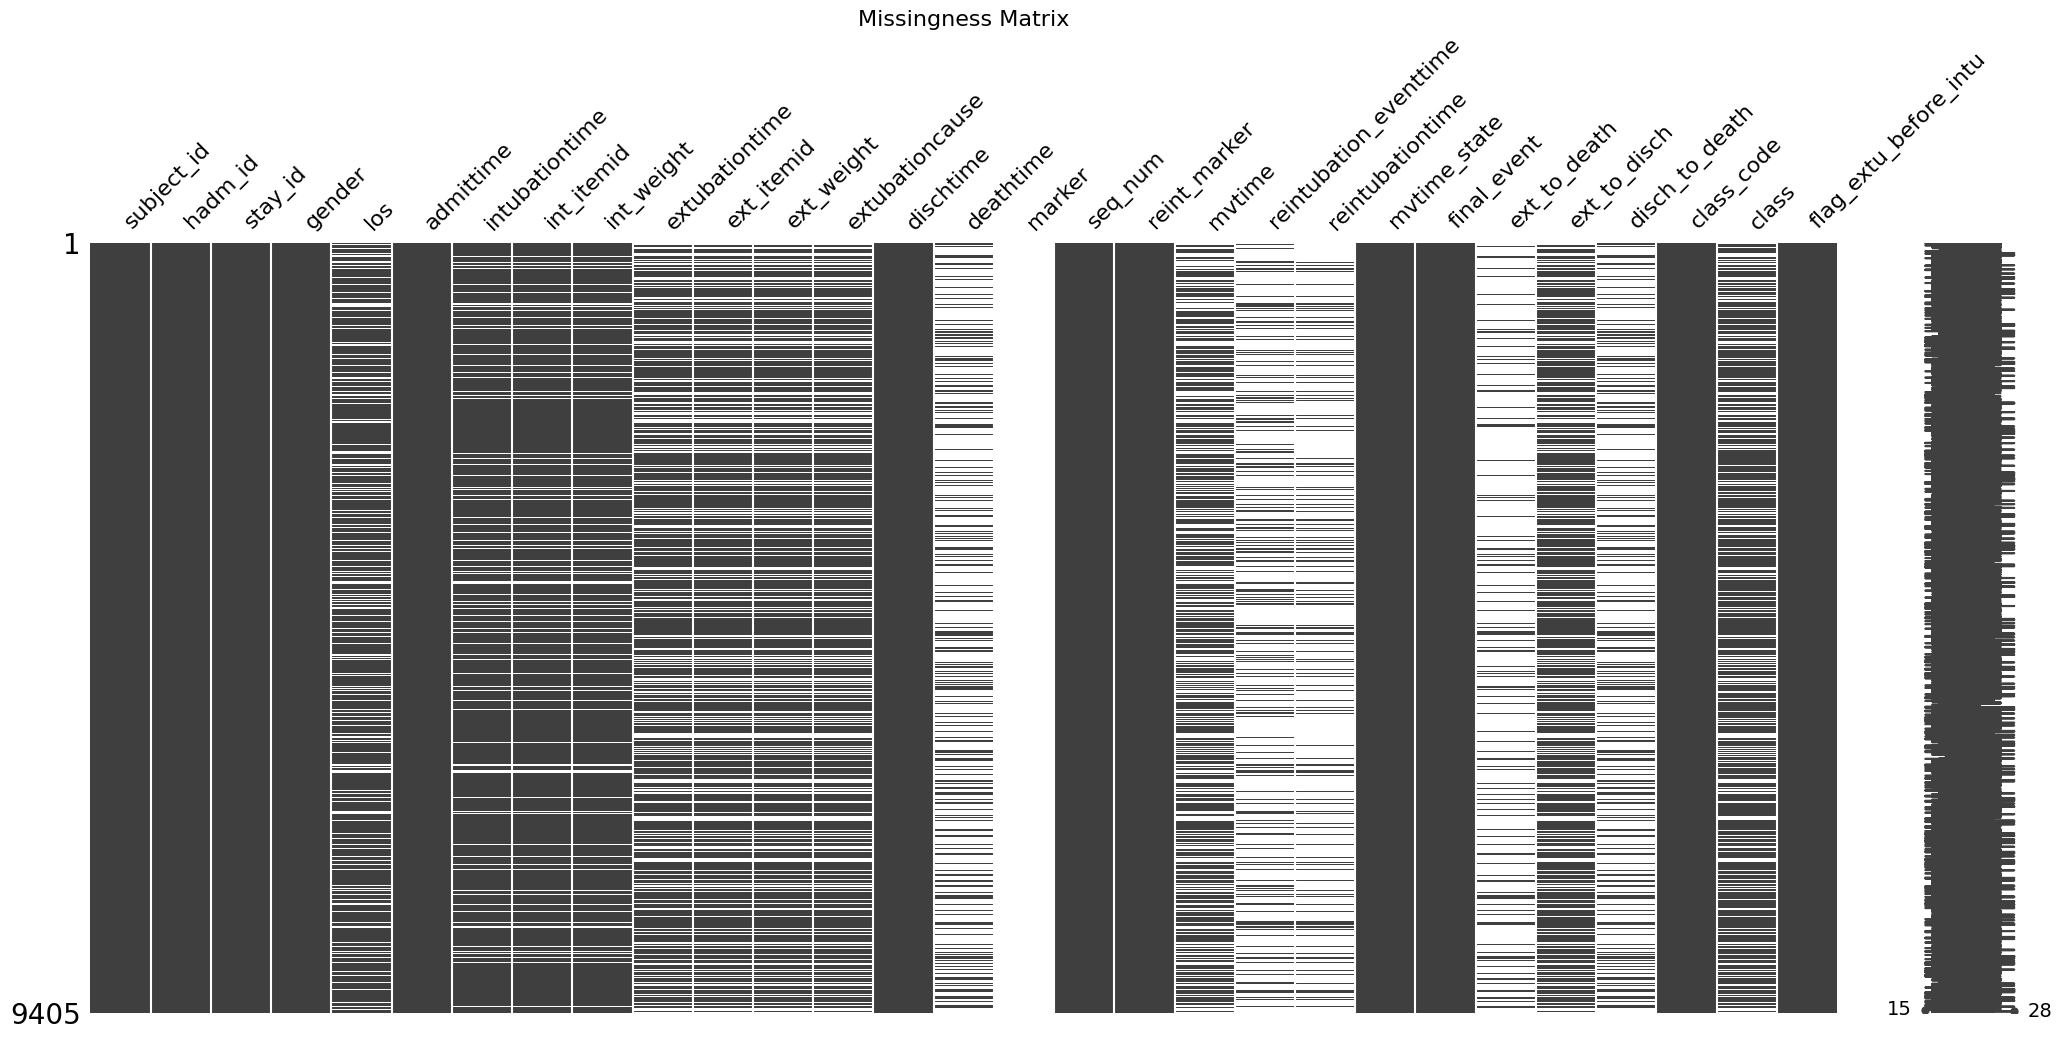

In [2]:
import missingno as msno
import matplotlib.pyplot as plt

# 00_subjectlist1_prepare02_alignment.ipynb 파일에서 최종적으로 저장되는 파일을 불러옴.
before_reconstruction = pd.read_csv('./data/intubation_extubation_before_reconstruction.csv', parse_dates=['admittime','intubationtime','extubationtime',\
                                    'dischtime','reintubation_eventtime','deathtime'])

# 결측치 행렬 생성
plt.figure(figsize=(20, 10))
msno.matrix(before_reconstruction)
plt.title('Missingness Matrix', fontsize=16)
plt.show()

#### 1-2. intubation-extubation 은 pairing 되어야 하므로 연속해서 intubation event가 있거나 연속해서 extubation event 가 있으면 에러로 볼 수 있음.


In [3]:
import src_unable as pairing   # 삽관 발관 페어링 관련 모듈
from src_unable import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src_unable import align
from src_unable import subject_classification as cls
from src.utils import utils

In [4]:
before_reconstruction.info() # (9405, 29)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9405 entries, 0 to 9404
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   subject_id              9405 non-null   int64         
 1   hadm_id                 9405 non-null   int64         
 2   stay_id                 9405 non-null   int64         
 3   gender                  9405 non-null   object        
 4   los                     7561 non-null   float64       
 5   admittime               9405 non-null   datetime64[ns]
 6   intubationtime          8434 non-null   datetime64[ns]
 7   int_itemid              8434 non-null   float64       
 8   int_weight              8434 non-null   float64       
 9   extubationtime          6899 non-null   datetime64[ns]
 10  ext_itemid              6899 non-null   float64       
 11  ext_weight              6899 non-null   float64       
 12  extubationcause         6899 non-null   object  

In [5]:
# before_reconstruction, unable_intu_extu를 조합하여 table을 만듦. table_for_dup = pd.concat([table, icu_data])과 같이 최종테이블에 들어가게 됨
# 추후 icu_data를 쓰게 되는 이유는 unable intu/extu로도 페어링할 수 없을 때 icu_data의 intime과 outtime을 참고하여 페어링함
table = align.intuextu_add_unable(before_reconstruction, unable_intu_extu) # 원본에 기록되어있는 intuextu 페어링과 unable intuextu | 시간 비교에 필요한 컬럼 추가

# 중복 제거, subject_id, hadm_id, stay_id, time, event_type이 모두 동일한 행 제거
table.sort_values(by=['subject_id','hadm_id','stay_id','time','data_type'], inplace = True)
table = table.drop_duplicates(subset=['subject_id', 'hadm_id', 'stay_id', 'time', 'event_type'], keep='first').reset_index(drop=True)

table = align.sort_intuextu(table) # 정렬 (삽/발관 시간이 같은 경우 intubation이 먼저 나옴)
table = align.duplicates_row_flag(table) # 연속해서 intubation이 있거나 extubation이 연속해서 있는 경우 flag_dup 생성
table = align.time_diff(table) # flag_dup인 행과 그 다음 행의 시간 차이 계산

c:\Users\inhae\Desktop\extubationfailure\조인해\final\src_unable\align.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intubation_df['data_type']='real'
c:\Users\inhae\Desktop\extubationfailure\조인해\final\src_unable\align.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extubation_df['data_type']='real'
c:\Users\inhae\Desktop\extubationfailure\조인해\final\src_unable\align.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

#### 1-3. error 타입 정의하고 해결


In [6]:
print(f'intubation or extubation 중복인 경우: {round(table[table.flag_dup].shape[0] / table.shape[0] * 100, 2)}%')
print()
print(table.info()) # (50835, 9)
table

intubation or extubation 중복인 경우: 27.02%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50361 entries, 0 to 50360
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   subject_id             50361 non-null  int64         
 1   hadm_id                50361 non-null  int64         
 2   stay_id                50361 non-null  int64         
 3   time                   50361 non-null  datetime64[ns]
 4   data_type              50361 non-null  object        
 5   flag_extu_before_intu  50361 non-null  bool          
 6   event_type             50361 non-null  object        
 7   extubationcause        6899 non-null   object        
 8   flag_dup               50361 non-null  bool          
 9   time_diff              13607 non-null  object        
dtypes: bool(2), datetime64[ns](1), int64(3), object(4)
memory usage: 3.2+ MB
None


,subject_id,hadm_id,stay_id,time,data_type,flag_extu_before_intu,event_type,extubationcause,flag_dup,time_diff
0,10001884,26184834,37510196,2131-01-11 04:30:00,real,False,intubation,NaN,True,0 days 03:30:00
1,10001884,26184834,37510196,2131-01-11 08:00:00,unable,False,intubation,NaN,False,NaT
2,10001884,26184834,37510196,2131-01-12 17:30:00,unable,False,extubation,NaN,True,0 days 00:10:00
3,10001884,26184834,37510196,2131-01-12 17:40:00,real,False,extubation,Planned Extubation,False,NaT
4,10001884,26184834,37510196,2131-01-13 04:00:00,unable,False,intubation,NaN,False,NaT
...,...,...,...,...,...,...,...,...,...,...
50356,19999840,21033226,38978960,2164-09-12 09:40:00,real,False,intubation,NaN,True,0 days 00:31:00
50357,19999840,21033226,38978960,2164-09-12 10:11:00,unable,False,intubation,NaN,False,NaT
50358,19999840,21033226,38978960,2164-09-12 16:00:00,unable,False,extubation,NaN,False,NaT
50359,19999840,21033226,38978960,2164-09-13 04:05:00,unable,False,intubation,NaN,False,NaT


In [7]:
table_ori = table.copy()

In [8]:
table = table_ori.copy()
table.time_diff = pd.to_timedelta(table.time_diff)
           
# intubation & 중복인 경우
table_intu_dup = table[(table.event_type == 'intubation') & (table.flag_dup)]
time_diff_criteria = table[(table.event_type == 'intubation')].time_diff.mean()

table['flag_intudup2_filttime'] = False
table['flag_add_extu'] = False # intu가 두 번 등장했을 때 첫번째의 extu가 없었기 때문에 생성해주기 위해 두번째 행에 flag를 주고 추후 flag 기준으로 -1분(우리가 지정한 임시 수치)으로 extu 생성

for idx_row, row in table_intu_dup.iterrows():
    group = []
    next_idx_row = idx_row + 1

    # time_diff가 평균시간(3시간 30분)보다 작은 경우
    if row.time_diff <= time_diff_criteria: 
        # data_type이 다른 경우는 삭제(unable intu - 원본 intu | 원본 intu - unable intu)
        if row.data_type != table.loc[next_idx_row].data_type: 
            group.append({"index": idx_row,"data_type": row.data_type})
            group.append({"index": next_idx_row,"data_type": table.loc[next_idx_row].data_type})
            dataframe = pd.DataFrame(group)

            cond_idx = dataframe[dataframe.data_type == 'unable']['index'].values[0] # intu가 세 번 등장하는 경우를 해결하기 위한 idx(real intu가 세 번 등장하는 경우는 없고, intu가 두 번 등장했을 때 unable intu의 idx()
            table.loc[cond_idx,'flag_intudup2_filttime'] = True
            table.loc[idx_row,'flag_dup'] = False # flag 초기화
            table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화
            
            # intu가 연달아 세 번 이상 나오는 경우
            # intu가 연달아 세 번 이상 나올 떄 중간의 intu가 삭제되면서 또 다시 intu 중복이 발생할 수 있는 경우를 해결하기 위한 조건 
            if (table.loc[next_idx_row].stay_id == table.loc[next_idx_row + 1].stay_id) and\
                (table.loc[next_idx_row + 1].event_type == 'intubation' and table.loc[next_idx_row + 1].data_type == 'real'):

                table.loc[next_idx_row + 1, 'flag_add_extu'] = True
                table.loc[next_idx_row,'flag_dup'] = False # flag 초기화
                table.loc[next_idx_row,'time_diff'] = pd.NaT # flag 초기화

        else:
            # 원본 intubation이 연달아 나오는 경우, extu 추가
            if row.data_type == 'real':
                table.loc[next_idx_row,'flag_add_extu'] = True
                table.loc[idx_row,'flag_dup'] = False # flag 초기화
                table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화

            else:
                print(row.hadm_id, 'unable이 두개 연속') # 아무것도 없어야 함

    # time_diff가 평균시간(3시간 30분)보다 큰 경우
    else:
        # data_type에 관계없이 extu 추가
        table.loc[next_idx_row,'flag_add_extu'] = True
        table.loc[idx_row,'flag_dup'] = False # flag 초기화
        table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화
        
table_after_intu_dup = table.copy()  


####  extubaiton 추가 및 unable intubation 삭제할 수 있도록 flag 지정
- intu 중복 시 뒤의 intubationtime -1분으로 extubation 추가

In [9]:
# extubation 추가
table_copy = table[table.flag_add_extu]

table_copy.loc[:,'time'] = table_copy.time - pd.Timedelta(minutes = 1)

table_copy.loc[:,'data_type'] = 'extu_added'
table_copy.loc[:,'event_type'] = 'extubation'
table_copy.loc[:,'flag_extu_before_intu'] = False
table_copy.loc[:,'flag_intudup2_filttime'] = False
table_copy.loc[:,'flag_add_extu'] = False
table_copy.loc[:,'flag_extudup2_filttime'] = False
table_copy.loc[:,'flag_add_intu'] = False
table_copy.loc[:,'flag_dup'] = False
table_copy.loc[:,'time_diff'] = pd.NaT

table = pd.concat([table,table_copy]).sort_values(by=['hadm_id','stay_id','time'])

C:\Users\inhae\AppData\Local\Temp\ipykernel_20376\3671244032.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_copy.loc[:,'flag_extudup2_filttime'] = False
C:\Users\inhae\AppData\Local\Temp\ipykernel_20376\3671244032.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_copy.loc[:,'flag_add_intu'] = False


In [10]:
print(table.shape) # (51861, 14)
table[(table.event_type == 'intubation') & (table.flag_dup)] # 아무것도 안 나와야 함

(52230, 14)


,subject_id,hadm_id,stay_id,time,data_type,flag_extu_before_intu,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime,flag_add_extu,flag_extudup2_filttime,flag_add_intu


- (B). extubation이 중복인 경우
- (B-1). 중복이 2개인 경우 (intubation - extubation - extubation 같이 2개의 extubation 연달아 나오는 경우)
    - 원본 extubation - unable extubation 순서인 경우
        - extubation이 Unplanned이면, intubation 추가
        - planned면, time_diff가 평균시간(4시간)보다 작으면 unable 삭제, 크면 앞의 extubationtime +1분으로 intubation 추가

    - unable extubation - 원본 extubatione 순서인 경우
        - time_diff가 평균시간(4시간)보다 작으면 unable 삭제, 크면 앞의 extubationtime +1분으로 intubation 추가

    - real extubation이 연달아 나오는 경우
        - 원래 extubation이 Unplanned이면, intubation 추가
        - planned면, time_diff가 평균시간(4시간)보다 작으면 unable 삭제, 크면 앞의 extubationtime +1분으로 intubation 추가

- (B-2) 중복이 3개
    - 위의 조건을 따름

In [11]:
table_before_extu_dup = table.copy()

In [12]:
table = table_before_extu_dup.copy()
table.time_diff = pd.to_timedelta(table.time_diff)

# extubation & 중복인 경우
table_extu_dup = table[(table.event_type == 'extubation') & (table.flag_dup)]
time_diff_extu_criteria = table[(table.event_type == 'extubation')].time_diff.mean()

table['flag_extudup2_filttime'] = False
table['flag_add_intu'] = False

for idx_row, row in table_extu_dup.iterrows():
    next_idx_row = idx_row + 1
    
    # 1. real-unable인 경우 (real extubaion이 unplanned일 경우는 intubation 추가, 그외엔 평균시간에 따라 처리)
    if (row.data_type == 'real') & (table.loc[next_idx_row].data_type == 'unable'):
        if isinstance(row.extubationcause, str) and 'Unplanned' in row.extubationcause:
            table.loc[idx_row,'flag_add_intu'] = True
            table.loc[idx_row,'flag_dup'] = False # flag 초기화
            table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화

        else:
            # 평균시간(time_diff_extu_criteria)보다 작은 경우
            if row.time_diff <= time_diff_extu_criteria:
                table.loc[next_idx_row,'flag_extudup2_filttime'] = True
                table.loc[idx_row,'flag_dup'] = False # flag 초기화
                table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화
                
                # extu가 연달아 세 번 이상 나오는 경우
                # extu가 연달아 세 번 이상 나올 떄 중간의 extu가 삭제되면서 또 다시 extu 중복이 발생할 수 있는 경우를 해결하기 위한 조건  
                if (table.loc[next_idx_row].stay_id == table.loc[next_idx_row + 1].stay_id) and\
                    (table.loc[next_idx_row + 1].event_type == 'extubation' and table.loc[next_idx_row + 1].data_type == 'real'):
                    table.loc[idx_row,'flag_add_intu'] = True # intu 추가를 위한 flag
                    table.loc[next_idx_row,'flag_dup'] = False # flag 초기화
                    table.loc[next_idx_row,'time_diff'] = pd.NaT # flag 초기화

            # 평균시간(time_diff_extu_criteria)보다 큰 경우
            else:
                table.loc[idx_row,'flag_add_intu'] = True
                table.loc[idx_row,'flag_dup'] = False # flag 초기화
                table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화

    # 2. unable - real인 경우 (평균시간보다 작은 경우는 unable extubation 삭제, 큰 경우는 intubation 추가)
    elif (row.data_type == 'unable') & (table.loc[next_idx_row].data_type == 'real'):
        
        # 평균시간(time_diff_extu_criteria)보다 작은 경우
        if row.time_diff <= time_diff_extu_criteria:
            table.loc[idx_row,'flag_extudup2_filttime'] = True
            table.loc[idx_row,'flag_dup'] = False # flag 초기화
            table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화

        # 평균시간(time_diff_extu_criteria)보다 큰 경우
        else:
            table.loc[idx_row,'flag_add_intu'] = True
            table.loc[idx_row,'flag_dup'] = False # flag 초기화
            table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화

    # 3. real extubation이 연달아 나오는 경우 (real - real, 삭제하지 않고 intubation 추가)
    elif (row.data_type == 'real') & (table.loc[next_idx_row].data_type == 'real'):
        table.loc[idx_row,'flag_add_intu'] = True
        table.loc[idx_row,'flag_dup'] = False # flag 초기화
        table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화

    else:
        print(row.hadm_id) # 아무것도 안 나와야 함

table_after_extu_dup2 = table.copy()

####  intubaiton 추가 및 unable extubation 삭제할 수 있도록 flag 지정

In [13]:
# intubation 추가
# flag_add_intu : extu가 연달아 나올 때, time_diff가 평균 시간(time_diff_extu_criteria)보다 큰 경우나 real extu가 연달아 나오는 경우, 두번째 extu 앞에 intu(첫번째 extu 시간 + 1분)를 삽입하기 위한 flag
table_copy = table[table.flag_add_intu]

table_copy.loc[:,'time'] = table_copy.time + pd.Timedelta(minutes = 1)

table_copy.loc[:,'data_type'] = 'intu_added'
table_copy.loc[:,'event_type'] = 'intubation'
table_copy.loc[:,'flag_dup'] = False
table_copy.loc[:,'flag_extu_before_intu'] = False
table_copy.loc[:,'flag_intudup2_filttime'] = False
table_copy.loc[:,'flag_add_extu'] = False
table_copy.loc[:,'flag_extudup2_filttime'] = False
table_copy.loc[:,'flag_add_intu'] = False
table_copy.loc[:,'time_diff'] = pd.NaT
table_copy.loc[:,'extubationcause'] = None

table = pd.concat([table,table_copy]).sort_values(by=['hadm_id','stay_id','time']).reset_index(drop = True)

In [14]:
table_after_add_extu = table.copy()

- (C). stay_id가 하나인 경우
- 참고할 unable 삽/발관과 원본 삽/발관이 존재하지 않음
- 따라서 icu 퇴실, 입실 시간으로 결측 행을 채움
- 그럼에도 채워지지 않는 행은 퇴원 시간으로 채움

In [15]:
table = table_after_add_extu.copy()

In [16]:
table.stay_id.value_counts()[table.stay_id.value_counts() == 1].sum()

141

In [ ]:
# 데이터 불러오기
adults_icu = pd.read_csv('./data/adults_icu.csv', parse_dates = ['admittime','dischtime'])   # 성인 환자 정보
icustays = pd.read_csv('./origin_data/icustays.csv')

icustays.intime = pd.to_datetime(icustays.intime)
icustays.outtime = pd.to_datetime(icustays.outtime)

In [18]:
adults_icu.info() # (73181, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73181 entries, 0 to 73180
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      73181 non-null  int64         
 1   subject_id      73181 non-null  int64         
 2   gender          73181 non-null  object        
 3   anchor_age      73181 non-null  int64         
 4   hadm_id         73181 non-null  float64       
 5   admittime       73181 non-null  datetime64[ns]
 6   dischtime       73181 non-null  datetime64[ns]
 7   deathtime       8321 non-null   object        
 8   stay_id         73181 non-null  float64       
 9   first_careunit  73181 non-null  object        
 10  last_careunit   73181 non-null  object        
 11  intime          73181 non-null  object        
 12  outtime         73181 non-null  object        
 13  los             73181 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(3), object(6)


In [19]:
# stay_id가 33741058인 환자의 dicshtime이 날짜는 있지만 시간은 기록되어있지 않음. 
# 처음 intubationtime으로 대체할 때 오류가 생기므로 이 사람의 처음 extubation은 삭제
# pairing해줄 dicshtime정보가 없음

In [20]:
# filtered_rows = table[table['stay_id'] == 33741058.0]
# last_index = filtered_rows.index[-1]
# table = table.drop(last_index)

### AI 입력으로 넣기 위해 비어있는 데이터 채우기 1단계
extu가 intu보다 앞에 있는 경우에도 icu 입실 시간이 extu시간보다 빠를 경우에만 icu 입실 시간으로 intu를 해당 extu보다 앞에 삽입\
intu가 extu보다 뒤에 있는 경우에도 icu 퇴실 시간이 intu시간보다 늦을 경우에만 icu 퇴실 시간으로 extu를 해당 intu보다 뒤에 삽입

In [21]:
table = align.sort_intuextu(table) # 정렬 (같은 시간일 경우 intubation이 먼저 나옴)

# intubation으로 끝나는 경우
intu_last = table.groupby('stay_id').tail(1)[table.groupby('stay_id').tail(1).event_type == 'intubation']
# extubation으로 시작하는 경우
extu_first = table.groupby('stay_id').head(1)[table.groupby('stay_id').head(1).event_type == 'extubation']

list = []

# extubation이 없어 짝이 안 맞는 경우
for idx, row in intu_last.iterrows():
    icu = icustays[icustays.stay_id == row.stay_id]

    # icu outtime이 마지막 행의 intubation 시간보다 클 때만 추가
    if (icu.outtime >= row.time).any():
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': icu.outtime.values[0],\
                     'data_type':'icu_out','flag_extu_before_intu':False,'event_type': 'extubation', 'flag_dup':False,\
                    'flag_intudup2_filttime' : False,'flag_add_extu' : False,'flag_extudup2_filttime' : False,'flag_add_intu' : False})
    else:
        dischtime = adults_icu[adults_icu.stay_id == row.stay_id].dischtime
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': dischtime.values[0],\
                     'data_type':'dischtime','flag_extu_before_intu':False,'event_type': 'extubation', 'flag_dup':False,\
                    'flag_intudup2_filttime' : False,'flag_add_extu' : False,'flag_extudup2_filttime' : False,'flag_add_intu' : False})

# intubation이 없어 짝이 안 맞는 경우
for idx, row in extu_first.iterrows():
    icu = icustays[icustays.stay_id == row.stay_id]

    # icu intime이 처음 행의 extubation 시간보다 작을 때만 추가
    if (icu.intime <= row.time).any():
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': icu.intime.values[0],\
                     'data_type':'icu_in','flag_extu_before_intu':False,'event_type': 'intubation', 'flag_dup':False,\
                    'flag_intudup2_filttime' : False,'flag_add_extu' : False, 'flag_extudup2_filttime' : False,'flag_add_intu' : False})
        
    else:
        admittime = adults_icu[adults_icu.stay_id == row.stay_id].admittime
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': admittime.values[0],\
                     'data_type':'admittime','flag_extu_before_intu':False,'event_type': 'intubation', 'flag_dup':False,\
                    'flag_intudup2_filttime' : False,'flag_add_extu' : False, 'flag_extudup2_filttime' : False,'flag_add_intu' : False})

In [22]:
icu_data = pd.DataFrame(list)
table_intuextu_icu = pd.concat([table, icu_data])

print(table_intuextu_icu.shape) # (53204, 14)
table_intuextu_icu[table_intuextu_icu.flag_dup] # 아무것도 없어야 함

(54048, 14)


,subject_id,hadm_id,stay_id,time,data_type,flag_extu_before_intu,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime,flag_add_extu,flag_extudup2_filttime,flag_add_intu


In [23]:
print(table_intuextu_icu.info())
print()
print('table_intuextu_icu.columns')
print(table_intuextu_icu.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 54048 entries, 0 to 205
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   subject_id              54048 non-null  int64          
 1   hadm_id                 54048 non-null  int64          
 2   stay_id                 54048 non-null  int64          
 3   time                    54048 non-null  datetime64[ns] 
 4   data_type               54048 non-null  object         
 5   flag_extu_before_intu   54048 non-null  bool           
 6   event_type              54048 non-null  object         
 7   extubationcause         6899 non-null   object         
 8   flag_dup                54048 non-null  bool           
 9   time_diff               0 non-null      timedelta64[ns]
 10  flag_intudup2_filttime  54048 non-null  bool           
 11  flag_add_extu           54048 non-null  bool           
 12  flag_extudup2_filttime  54048 non-null 

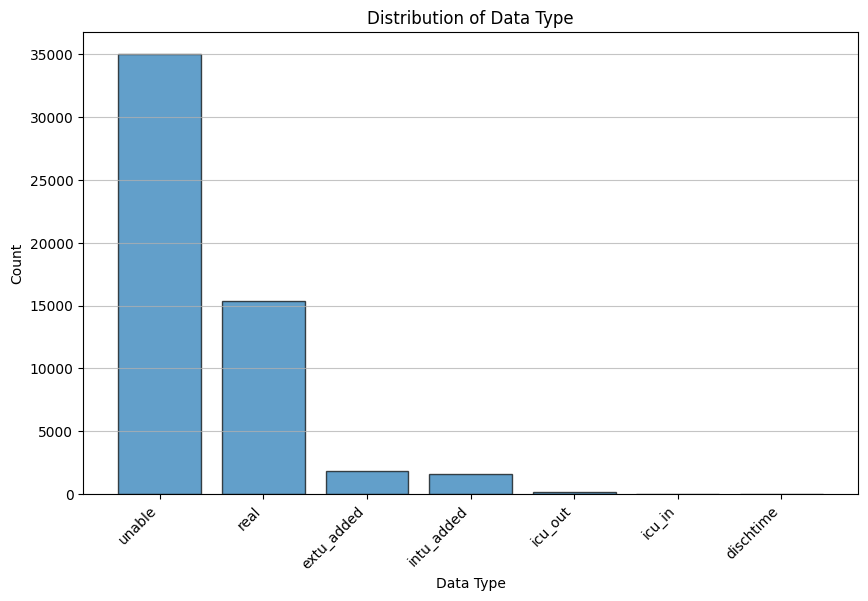

data_type
unable        35028
real          15333
extu_added     1869
intu_added     1612
icu_out         193
icu_in           11
dischtime         2
Name: count, dtype: int64
Total: 54048


In [24]:
data_type_count = table_intuextu_icu.data_type.value_counts()

plt.figure(figsize=(10, 6))
plt.bar(data_type_count.index, data_type_count.values, edgecolor = 'k',alpha = 0.7)
plt.title('Distribution of Data Type')
plt.xlabel('Data Type')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right') 
plt.show()

print(data_type_count)
print(f'Total: {data_type_count.sum()}')

data type 설명
- unable   : gcs의 unable을 기준으로 생성한 삽/발관
- real     : 원본 삽/발관
- added    : duplicate_intu, duplicate_extu 함수로 생성된 삽/발관
- icu_in   : 참고할 unable 삽/발관과 원본 삽/발관이 존재하지 않아 icu 입실 시간으로 채움
- icu_out  : 참고할 unable 삽/발관과 원본 삽/발관이 존재하지 않아 icu 퇴실 시간으로 채움
- dischtime: icu 퇴실 시간이 없는 경우 퇴원 시각으로 채움

#### 3-4 환자 정보 추가

- table_intuextu_icu_patients_paired는 intu/extu 중복 해결한 테이블 (unable_intu_extu 테이블에서 int/ext정보와 함께 intubationtime이 비어있을 경우 admittime을 채워넣고 extubationtime이 비어있을 경우 dischtime을 채워서 작업한 결과)
- 이번에는 unable_intu_extu 테이블에서 환자 정보 컬럼 슬라이싱해서 patients_info 테이블구성
- table_intuextu_icu_patients_paired과 patients_info을 hadm_id를 기준으로 병합하여 reintubation_unable = get_reintubation(table_intuextu_icu_patients)와 같이 Reintubationtime 관련 컬럼추가함수에 들어갈 table_intuextu_icu_patients를 만듦

In [25]:
# 환자 정보
patients_info = adults_icu[['subject_id','stay_id','gender','los','admittime','dischtime','deathtime']]#.drop_duplicates(subset = ["subject_id"])

table_intuextu_icu_patients = pd.merge(patients_info, table_intuextu_icu, on = ['subject_id', 'stay_id'], how = 'inner')
table_intuextu_icu_patients

,subject_id,stay_id,gender,los,admittime,dischtime,deathtime,hadm_id,time,data_type,flag_extu_before_intu,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime,flag_add_extu,flag_extudup2_filttime,flag_add_intu
0,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-11 04:30:00,real,False,intubation,NaN,False,NaT,False,False,False,False
1,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-11 08:00:00,unable,False,intubation,NaN,False,NaT,True,False,False,False
2,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-12 17:30:00,unable,False,extubation,NaN,False,NaT,False,False,True,False
3,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-12 17:40:00,real,False,extubation,Planned Extubation,False,NaT,False,False,False,False
4,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-13 04:00:00,unable,False,intubation,NaN,False,NaT,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54043,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-12 09:40:00,real,False,intubation,NaN,False,NaT,False,False,False,False
54044,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-12 10:11:00,unable,False,intubation,NaN,False,NaT,True,False,False,False
54045,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-12 16:00:00,unable,False,extubation,NaN,False,NaT,False,False,False,False
54046,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-13 04:05:00,unable,False,intubation,NaN,False,NaT,False,False,False,False


#### 3-5 flag 제거
- flag_extu_before_intu: extu가 intu보다 이전에 나온 경우
- flag_intudup2_filttime: intu가 연달아 나올 때, data_type이 서로 다르고(unable intu 다음에 원본 intu | 원본 intu 다음에 unable intu) time_diff가 평균 시간보다 작은 경우
- flag_extudup2_filttime: extu가 연달아 나올 때, data_type이 서로 다르고(unable extu 다음에 원본 extu | 원본 extu 다음에 unable extu) time_diff가 평균 시간보다 작은 경우

In [26]:
table_flag = table_intuextu_icu_patients.copy()

In [27]:
table = table_flag.copy()
table = table[~(table.flag_intudup2_filttime)]
table # 48530  

,subject_id,stay_id,gender,los,admittime,dischtime,deathtime,hadm_id,time,data_type,flag_extu_before_intu,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime,flag_add_extu,flag_extudup2_filttime,flag_add_intu
0,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-11 04:30:00,real,False,intubation,NaN,False,NaT,False,False,False,False
2,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-12 17:30:00,unable,False,extubation,NaN,False,NaT,False,False,True,False
3,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-12 17:40:00,real,False,extubation,Planned Extubation,False,NaT,False,False,False,False
4,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-13 04:00:00,unable,False,intubation,NaN,False,NaT,False,False,False,False
5,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-13 20:00:00,unable,False,extubation,NaN,False,NaT,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54042,19999442,32336619.0,M,6.950370,2148-11-19 10:00:00,2148-12-04 16:25:00,NaN,26785317,2148-11-20 14:15:00,real,False,extubation,Planned Extubation,False,NaT,False,False,False,False
54043,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-12 09:40:00,real,False,intubation,NaN,False,NaT,False,False,False,False
54045,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-12 16:00:00,unable,False,extubation,NaN,False,NaT,False,False,False,False
54046,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-13 04:05:00,unable,False,intubation,NaN,False,NaT,False,False,False,False


In [28]:
table = table_flag.copy()
table = table[~(table.flag_intudup2_filttime)]
table = table[~(table.flag_extudup2_filttime)]
table # 43922    

,subject_id,stay_id,gender,los,admittime,dischtime,deathtime,hadm_id,time,data_type,flag_extu_before_intu,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime,flag_add_extu,flag_extudup2_filttime,flag_add_intu
0,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-11 04:30:00,real,False,intubation,NaN,False,NaT,False,False,False,False
3,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-12 17:40:00,real,False,extubation,Planned Extubation,False,NaT,False,False,False,False
4,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-13 04:00:00,unable,False,intubation,NaN,False,NaT,False,False,False,False
5,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-13 20:00:00,unable,False,extubation,NaN,False,NaT,False,False,False,False
6,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-14 08:08:00,unable,False,intubation,NaN,False,NaT,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54042,19999442,32336619.0,M,6.950370,2148-11-19 10:00:00,2148-12-04 16:25:00,NaN,26785317,2148-11-20 14:15:00,real,False,extubation,Planned Extubation,False,NaT,False,False,False,False
54043,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-12 09:40:00,real,False,intubation,NaN,False,NaT,False,False,False,False
54045,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-12 16:00:00,unable,False,extubation,NaN,False,NaT,False,False,False,False
54046,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-13 04:05:00,unable,False,intubation,NaN,False,NaT,False,False,False,False


In [29]:
# stay_id별 intu, extu의 개수가 다른지 확인하기 위한 코드
df = table.groupby('stay_id').event_type.value_counts().reset_index()
df.loc[:, 'extu_count'] = df.groupby('stay_id')['count'].shift(-1)

df[(df['extu_count'].notna()) & (df['count'] != df['extu_count'])] # 아무것도 안 나와야 함

,stay_id,event_type,count,extu_count


In [30]:
table_check = table.copy()
table_check = align.sort_intuextu(table_check) # 정렬 (삽/발관 시간이 같은 경우 intubation이 먼저 나옴)
table_check = align.duplicates_row_flag(table_check) # 연속해서 intubation이 있거나 extubation이 연속해서 있는 경우 flag_dup 생성

table_check[table_check.flag_dup] # 최종 점검, 아무것도 안 나와야 함

,subject_id,stay_id,gender,los,admittime,dischtime,deathtime,hadm_id,time,data_type,flag_extu_before_intu,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime,flag_add_extu,flag_extudup2_filttime,flag_add_intu


#### 3-6 pairing 및 seq 부여

event_type이 intu인 경우 테이블을 intubation_table\
event_type이 extu인 경우 테이블을 extubation_table

- intubation_table, extubation_table을 id들을 기준으로 intu 이후의 시간과 가장 가까운 extu시간을 열 방향으로 배열
- 문제, 삭제에 해당하는 행(flag_intudup2_filttime, flag_intudupover2_filttime, flag_extudup2_filttime, flag_extudupover2_filttime 컬럼이 True인 행)을 삭제하지 않아 짝이 맞지 않을 수 있다

In [31]:
table_flag_delete = table.copy()

In [32]:
# 행 방향으로 존재하던 event를 subject_id, hadm_id, stay_id 기준으로 intu, extu를 열 방향으로 배열
table_tmp = table_flag_delete[:].copy()

# intubation, extubation 페어링
intubation_table = table_tmp[table_tmp.event_type == 'intubation'].rename(columns={'time':'intubationtime'})
extubation_table = table_tmp[table_tmp.event_type == 'extubation'].rename(columns = {'time':'extubationtime'})

intubation_table['intubationtime'] = pd.to_datetime(intubation_table['intubationtime'])
extubation_table['extubationtime'] = pd.to_datetime(extubation_table['extubationtime'])
                                
# 테이블 시간 정렬
intubation_df = intubation_table.sort_values('intubationtime')
extubation_df = extubation_table.sort_values('extubationtime')

paired_df = pd.merge_asof(
    intubation_df[['subject_id', 'stay_id', 'gender', 'los', 'admittime', 'dischtime',
       'deathtime', 'hadm_id', 'intubationtime', 'data_type',
       'flag_extu_before_intu', 'event_type', 'flag_dup',
       'time_diff', 'flag_intudup2_filttime', 'flag_add_extu']],
       
    extubation_df[['hadm_id', 'subject_id', 'stay_id', 'extubationtime', 'data_type','flag_extu_before_intu', 'event_type', 'extubationcause', 'flag_dup',
       'time_diff','flag_extudup2_filttime', 'flag_add_intu']],
       
    left_on='intubationtime',
    right_on='extubationtime',
    by=['subject_id', 'hadm_id', 'stay_id'],  # 같은 subject_id, hadm_id, stay_id 기준으로
    direction='forward'  # intubation 이후의 가장 가까운 extubation 시간과 페어링
)

# 테이블 페어링 후 복사본 생성
table_intuextu_icu_patients_paired = paired_df.copy()

# 열 이름 변경
table_intuextu_icu_patients_paired.rename(columns = {'data_type_x':'intu_data', 'data_type_y':'extu_data', 'extubationcause_y':'extubationcause'}, inplace = True)
table_intuextu_icu_patients_paired.drop(columns = ['event_type_x','event_type_y'], inplace = True)
for word in table_intuextu_icu_patients_paired.columns:
    if word.split('_')[-1] == 'x':
        replace_word = 'int_' + '_'.join(word.split('_')[:-1])
        table_intuextu_icu_patients_paired.rename(columns = {word:replace_word}, inplace = True)

    elif word.split('_')[-1] == 'y':
        replace_word = ('ext_' + '_'.join(word.split('_')[:-1]))
        table_intuextu_icu_patients_paired.rename(columns = {word:replace_word}, inplace = True)
    
print(table_intuextu_icu_patients_paired.columns)

Index(['subject_id', 'stay_id', 'gender', 'los', 'admittime', 'dischtime',
       'deathtime', 'hadm_id', 'intubationtime', 'intu_data',
       'int_flag_extu_before_intu', 'int_flag_dup', 'int_time_diff',
       'flag_intudup2_filttime', 'flag_add_extu', 'extubationtime',
       'extu_data', 'ext_flag_extu_before_intu', 'extubationcause',
       'ext_flag_dup', 'ext_time_diff', 'flag_extudup2_filttime',
       'flag_add_intu'],
      dtype='object')


In [33]:
# ex
# extu가 연달아 있었는데 flag_extudup2_filttime로 인해 unable extu가 사라지게 되면서 extu가 연달아 있던 문제가 해결되고 intu와 extu의 짝이 맞게 됨
table_flag[table_flag.hadm_id == 29981653]

,subject_id,stay_id,gender,los,admittime,dischtime,deathtime,hadm_id,time,data_type,flag_extu_before_intu,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime,flag_add_extu,flag_extudup2_filttime,flag_add_intu
50185,19326831,32431171.0,F,17.289711,2157-07-31 13:08:00,2157-10-14 14:00:00,NaN,29981653,2157-08-20 01:04:00,real,False,intubation,NaN,False,NaT,False,False,False,False
50186,19326831,32431171.0,F,17.289711,2157-07-31 13:08:00,2157-10-14 14:00:00,NaN,29981653,2157-08-20 08:14:00,extu_added,False,extubation,NaN,False,NaT,False,False,False,False
50187,19326831,32431171.0,F,17.289711,2157-07-31 13:08:00,2157-10-14 14:00:00,NaN,29981653,2157-08-20 08:15:00,unable,False,intubation,NaN,False,NaT,False,True,False,False
50188,19326831,32431171.0,F,17.289711,2157-07-31 13:08:00,2157-10-14 14:00:00,NaN,29981653,2157-08-22 00:00:00,unable,False,extubation,NaN,False,NaT,False,False,False,False
50189,19326831,32431171.0,F,17.289711,2157-07-31 13:08:00,2157-10-14 14:00:00,NaN,29981653,2157-08-22 08:51:00,unable,False,intubation,NaN,False,NaT,False,False,False,False
50190,19326831,32431171.0,F,17.289711,2157-07-31 13:08:00,2157-10-14 14:00:00,NaN,29981653,2157-08-27 10:00:00,unable,False,extubation,NaN,False,NaT,False,False,False,False
50191,19326831,32431171.0,F,17.289711,2157-07-31 13:08:00,2157-10-14 14:00:00,NaN,29981653,2157-08-27 20:00:00,unable,False,intubation,NaN,False,NaT,False,False,False,False
50192,19326831,32431171.0,F,17.289711,2157-07-31 13:08:00,2157-10-14 14:00:00,NaN,29981653,2157-09-01 08:00:00,unable,False,extubation,NaN,False,NaT,False,False,True,False
50193,19326831,32431171.0,F,17.289711,2157-07-31 13:08:00,2157-10-14 14:00:00,NaN,29981653,2157-09-01 09:18:00,real,False,extubation,Planned Extubation,False,NaT,False,False,False,False


In [34]:
# ex
# 결과
table_intuextu_icu_patients_paired[table_intuextu_icu_patients_paired.hadm_id == 29981653]\
    [['subject_id', 'hadm_id', 'stay_id', 'intubationtime','extubationtime']]

,subject_id,hadm_id,stay_id,intubationtime,extubationtime
12272,19326831,29981653,32431171.0,2157-08-20 01:04:00,2157-08-20 08:14:00
12274,19326831,29981653,32431171.0,2157-08-20 08:15:00,2157-08-22 00:00:00
12275,19326831,29981653,32431171.0,2157-08-22 08:51:00,2157-08-27 10:00:00
12283,19326831,29981653,32431171.0,2157-08-27 20:00:00,2157-09-01 09:18:00


In [35]:
print(f'(Before) before_reconstruction_row_count: {before_reconstruction.shape[0]}') 
print(f'(After) subjectlist2_unable_row_count: {table_intuextu_icu_patients_paired.shape[0]}')

(Before) before_reconstruction_row_count: 9405
(After) subjectlist2_unable_row_count: 21961


In [36]:
print(before_reconstruction.subject_id.nunique()) # 6709
print(table_intuextu_icu_patients_paired.subject_id.nunique()) # 6709

6709
6709


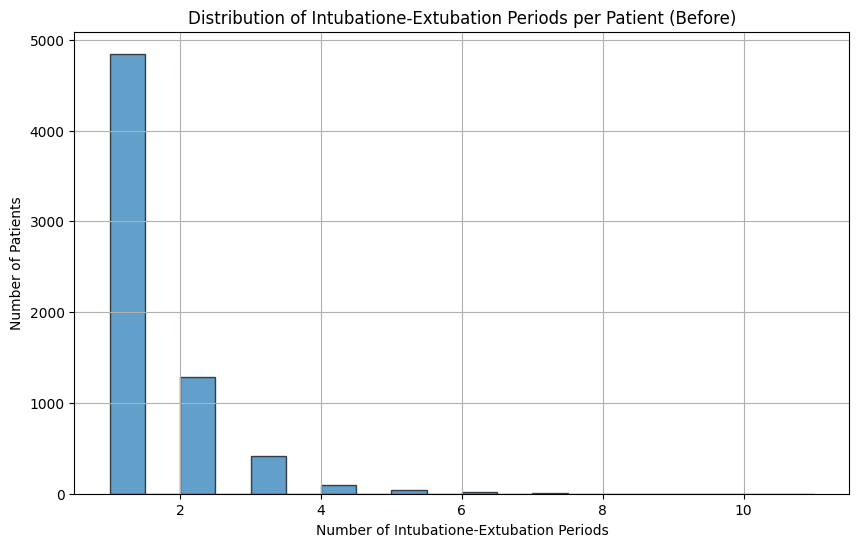

Before
count    6709.000000
mean        1.401848
std         0.780523
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        11.000000
Name: count, dtype: float64


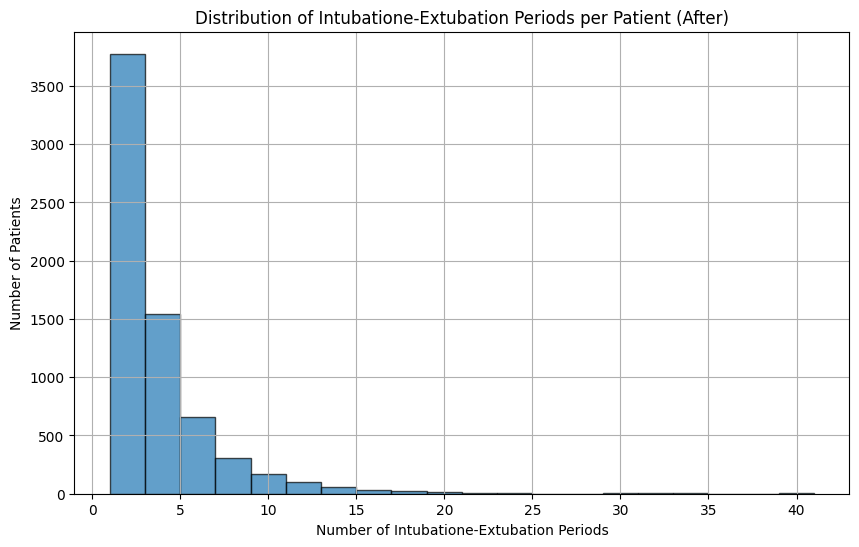

After
count    6709.000000
mean        3.273364
std         3.295853
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        41.000000
Name: count, dtype: float64


In [37]:
# 환자별 삽/발관 횟수 분포

# 환자별 Intubatione-Extubaion(Before) 횟수 분포
patient_before_reconstruction_counts = before_reconstruction.subject_id.value_counts()
plt.figure(figsize=(10, 6))
patient_before_reconstruction_counts.hist(bins=20, edgecolor = 'k', alpha = 0.7)
plt.title('Distribution of Intubatione-Extubation Periods per Patient (Before)')
plt.xlabel('Number of Intubatione-Extubation Periods')
plt.ylabel('Number of Patients')
plt.show()

print('Before')
print(patient_before_reconstruction_counts.describe())


# 환자별 Intubatione-Extubaion(After) 횟수 분포
patient_table_intuextu_icu_patients_paired_counts = table_intuextu_icu_patients_paired.subject_id.value_counts()
plt.figure(figsize=(10, 6))
patient_table_intuextu_icu_patients_paired_counts.hist(bins=20, edgecolor = 'k', alpha = 0.7)
plt.title('Distribution of Intubatione-Extubation Periods per Patient (After)')
plt.xlabel('Number of Intubatione-Extubation Periods')
plt.ylabel('Number of Patients')
plt.show()

print('After')
print(patient_table_intuextu_icu_patients_paired_counts.describe())

## - Reintubationtime  관련 변수들 계산, 데이터 정리
- create_reintubation_columns(group, ignore_exist=False):
    * reint_marker, mvtime, reintubation_eventtime 및 reintubationtime 칼럼을 생성합니다. 
    * reintubation_eventtime는 timestamp 형태로 (nan), reintubationtime는 float 형태로 초기화합니다.
- get_mvtime(group):
    * 현재 행의 intubationtime과 extubationtime의 시간 차이를 구합니다 (분 단위; float).
    * 두 값 중 하나라도 null이면, mvtime은 null로 설정됩니다.
    
- carryover_next_intubationtime(group):
    * 다음행의 intubationtime을 현재행의 reintubation_eventtime 칼럼으로 가져옵니다.
   
- get_reint_marker(group):
    * 이 함수는 그룹 내의 행이 1개를 초과하는 경우,모든 행의 'reint_marker' 칼럼을 True로 설정합니다.
    * 이는 재삽관이 있는 그룹을 표시하는 데 사용됩니다.
    
- get_reintubationtime(group):
    * 'reintubation_eventtime' (다음 intubationtime)과 현재의 'extubationtime'의 시간차를 구합니다 (분 단위; float).
    

In [38]:
def get_reintubation(df):
    start_time = time.time()   # 소요시간 계산
    grouped_df = df.groupby(['hadm_id', 'stay_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Fetching reintubation data..."):

            patient_df = rnt.create_reintubation_columns(patient_df)   # reintubationtime 칼럼 초기화 (reint_marker, mvtime, 다음 발관 시간, 재삽관 시간)
            patient_df = rnt.get_mvtime(patient_df)   # 삽관시간과 발관시간의 차이 계산
            patient_df = rnt.carryover_next_intubationtime(patient_df)   # 다음 삽관시간 가져오기
            patient_df = rnt.get_reint_marker(patient_df)   # 환자별로 재삽관이 존재하는지 마킹
            patient_df = rnt.get_reintubationtime(patient_df)   # 재삽관 시간 계산하기
            
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)

        # 각 그룹별로 시퀀스 넘버링 해주기
        reintubation_df['seq_num'] = reintubation_df.groupby(['hadm_id', 'stay_id']).cumcount() + 1
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [39]:
table_intuextu_icu_patients_paired_reintu = get_reintubation(table_intuextu_icu_patients_paired)
table_intuextu_icu_patients_paired_reintu.info()

Fetching reintubation data...: 100%|██████████| 7330/7330 [00:16<00:00, 450.99it/s]


--- RUNTIME: 20.94 seconds ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21961 entries, 0 to 21960
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   subject_id                 21961 non-null  int64          
 1   stay_id                    21961 non-null  float64        
 2   gender                     21961 non-null  object         
 3   los                        21961 non-null  float64        
 4   admittime                  21961 non-null  datetime64[ns] 
 5   dischtime                  21961 non-null  datetime64[ns] 
 6   deathtime                  5872 non-null   object         
 7   hadm_id                    21961 non-null  int64          
 8   intubationtime             21961 non-null  datetime64[ns] 
 9   intu_data                  21961 non-null  object         
 10  int_flag_extu_before_intu  21961 non-null  bool           
 11  int_flag_dup           

In [40]:
table_intuextu_icu_patients_paired_reintu.to_csv('./data/table_intuextu_icu_patients_paired_reintu.csv')

- 환자군 분류 (ext failure, non-failure, etc.)

분류 코드
11 재삽관 없이 발관후 48시간 넘어 퇴원 | nonfailure

121 재삽관 없이 발관후 48시간 이내 사망 X | nonfailure

1221 재삽관 없이 발관후 24시간 이내 사망 | death

1222 재삽관 없이 발관후 24~48시간 이내 사망 | death

211 48시간 이내 재삽관 | failure

212 48시간 너머 재삽관 | nonfailure

221 최종 발관 이후 48시간 넘어 퇴원 | nonfailure

2221 최종 발관 이후 48시간 이내 사망 X | nonfailure

22221 최종 발관 이후 24시간 이내 사망 | death

22222 최종 발관 이후 24~48시간 이내 사망 | death

999 (null case)현발관-다음발관이 48시간 이내 | Failure

998 (null case)현삽관-다음삽관이 48시간 이내 | Failure

9999 (null case) non-failure 판단 불가 | 제거

In [41]:
# 데이터 임포트
table_intuextu_icu_patients_paired_reintu = pd.read_csv('./data/table_intuextu_icu_patients_paired_reintu.csv', index_col=0, \
                               parse_dates=['intubationtime', 'extubationtime', \
                                            'admittime', 'dischtime', 'deathtime'])

print(table_intuextu_icu_patients_paired_reintu.shape)   # (21961, 28)

(21961, 28)


In [42]:
def categorize_patients(df):
    # 분류 코드 기준
    categories = {
        "nonfailure": [11, 121, 212, 221, 2221],
        "failure": [211, 999, 998],
        "death": [1221, 1222, 22221, 22222]
    }

    start_time = time.time()   # 소요시간 계산

    # df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id', 'stay_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Categorizing extubation failure vs non-failure..."):

            patient_df = cls.init_class_columns(patient_df)   # flag_mvtime_state, ext_to_death, ext_to_disch, disch_to_death, class_code 칼럼 초기화
            patient_df = cls.fill_class_columns(patient_df)   # 초기화한 칼럼 값(flag_mvtime_state, ext_to_death, ext_to_disch, disch_to_death) 계산해서 채워주기
            patient_df = cls.classify_patients(patient_df)   # 행별로 케이스 분류해서 class_code 입력해주는 코드
            patient_df = cls.categorize_code(patient_df, categories)   # class_code 기반으로 extubation failure, non-failure 분류해주는 코드
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        subjects_df = pd.concat(df_list)
        subjects_df = subjects_df.reset_index(drop=True)

    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return subjects_df

In [43]:
subjectlist2_unable = categorize_patients(table_intuextu_icu_patients_paired_reintu)

print(f'Processed subjectlist2: {subjectlist2_unable.shape}')   # (21961, 35)

subjectlist2_unable.columns

Categorizing extubation failure vs non-failure...: 100%|██████████| 7330/7330 [00:48<00:00, 150.98it/s]


--- RUNTIME: 51.89 seconds ---
Processed subjectlist2: (21961, 35)


Index(['subject_id', 'stay_id', 'gender', 'los', 'admittime', 'dischtime',
       'deathtime', 'hadm_id', 'intubationtime', 'intu_data',
       'int_flag_extu_before_intu', 'int_flag_dup', 'int_time_diff',
       'flag_intudup2_filttime', 'flag_add_extu', 'extubationtime',
       'extu_data', 'ext_flag_extu_before_intu', 'extubationcause',
       'ext_flag_dup', 'ext_time_diff', 'flag_extudup2_filttime',
       'flag_add_intu', 'reint_marker', 'mvtime', 'reintubation_eventtime',
       'reintubationtime', 'seq_num', 'mvtime_state', 'final_event',
       'ext_to_death', 'ext_to_disch', 'disch_to_death', 'class_code',
       'class'],
      dtype='object')

In [44]:
table_intuextu_icu_patients_paired_reintu_category = subjectlist2_unable.copy()

In [45]:
subjectlist2_unable = table_intuextu_icu_patients_paired_reintu_category.copy()

In [46]:
subjectlist2_unable.head()

,subject_id,stay_id,gender,los,admittime,dischtime,deathtime,hadm_id,intubationtime,intu_data,...,reintubation_eventtime,reintubationtime,seq_num,mvtime_state,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
0,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-11 04:30:00,real,...,2131-01-13 04:00:00,620.0,1,False,False,10775.0,10775.0,0.0,211,failure
1,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-13 04:00:00,unable,...,2131-01-14 08:08:00,728.0,2,True,False,9195.0,9195.0,0.0,211,failure
2,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-14 08:08:00,unable,...,2131-01-19 00:00:00,1671.0,3,False,False,3426.0,3426.0,0.0,211,failure
3,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-19 00:00:00,unable,...,NaN,NaN,4,True,True,1275.0,1275.0,0.0,22221,death
4,10003400,38383343.0,F,16.069838,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,23559586,2137-08-17 21:21:00,real,...,2137-08-18 02:00:00,1.0,1,True,False,22506.0,22506.0,0.0,211,failure


In [47]:
# # real intu, real extu 시간이 같은 경우
# subjectlist2_unable[(subjectlist2_unable.intubationtime == subjectlist2_unable.extubationtime) & (subjectlist2_unable.intu_data== 'unable') & (subjectlist2_unable.intu_data == subjectlist2_unable.extu_data)] # 11

In [48]:
# 최종 데이터셋 flag적용 비논리적 데이터 삭제 
# mvtime은 extubationtime에서 intubationtime을 뺀 시간
# reintubationtime은 다음 intubationtime에서 현재 intubationtime을 뺀 시간
# task: mvtime과 reintubationtime이 음수인 데이터는 제거해야함
# subjectlist2_unable.mvtime.isna().sum() = 0 이 나옴 (na값이 존재하는 케이스가 발생할 수도 있기때문에 reintubationtime이 na거나 양수값이면 놔둠)
# (subjectlist2_unable.mvtime < 0).sum() = 0 이 나옴 (지금은 양수값만 있지만 음수값일 때 제거되도록 존재)
# subjectlist2_unable.reintubationtime.isna().sum() = 7330 가 나옴
# (subjectlist2_unable.reintubationtime >= 0).sum() = 14631 이 나옴

subjectlist2_unable = subjectlist2_unable[((subjectlist2_unable.mvtime.isna()) | (subjectlist2_unable.mvtime >= 0)) &\
              ((subjectlist2_unable.reintubationtime.isna()) | (subjectlist2_unable.reintubationtime >= 0))] # 0

In [49]:
subjectlist2_unable.shape[0]

21961

In [50]:
# indices_to_drop = intubation_extubation_before_reconstruction[
#     intubation_extubation_before_reconstruction['intubationtime'] > intubation_extubation_before_reconstruction['extubationtime']
# ].index

# # 해당 인덱스를 사용하여 데이터프레임에서 행 삭제
# intubation_extubation_before_reconstruction = intubation_extubation_before_reconstruction.drop(indices_to_drop)
# intubation_extubation_before_reconstruction

<Figure size 2000x1000 with 0 Axes>

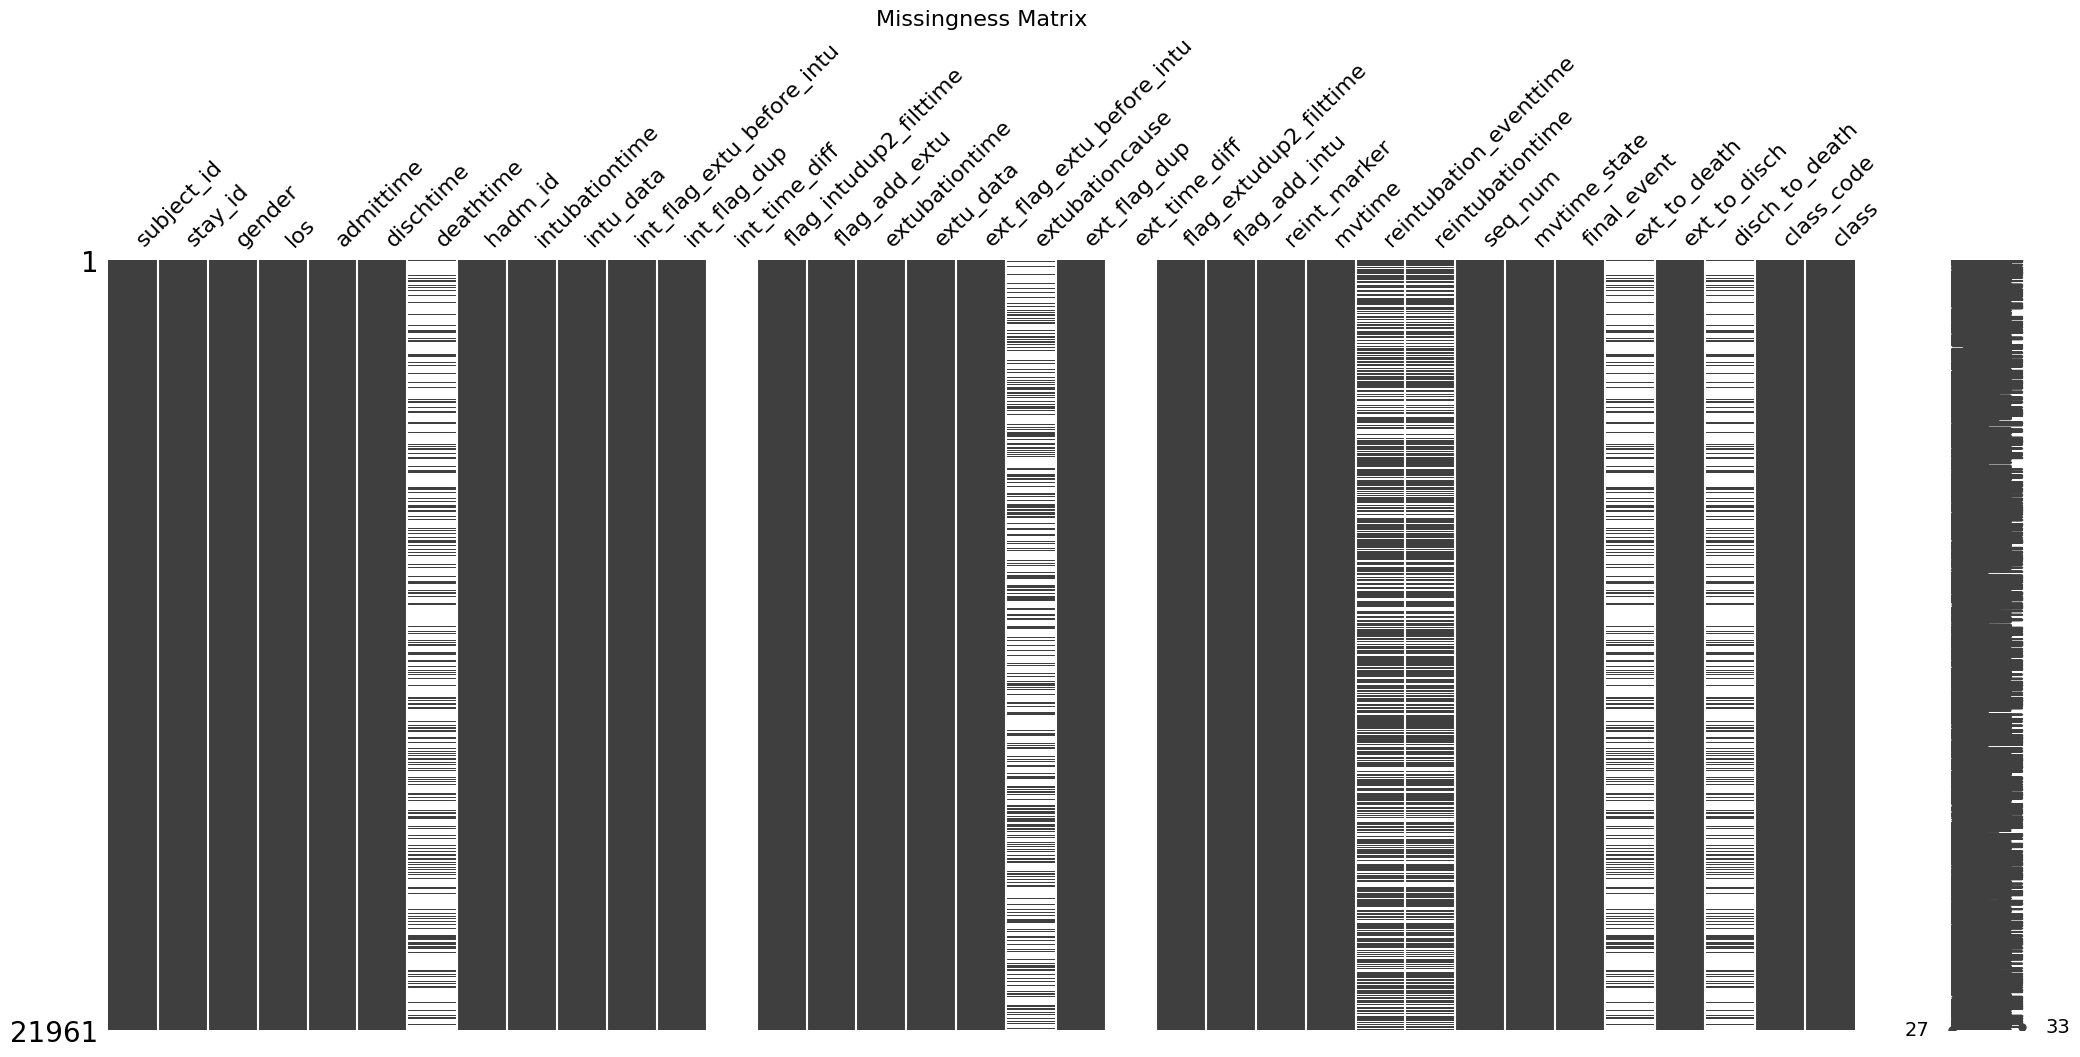

In [51]:
# 결측치 행렬 생성
plt.figure(figsize=(20, 10))
msno.matrix(subjectlist2_unable)
plt.title('Missingness Matrix', fontsize=16)
plt.show()

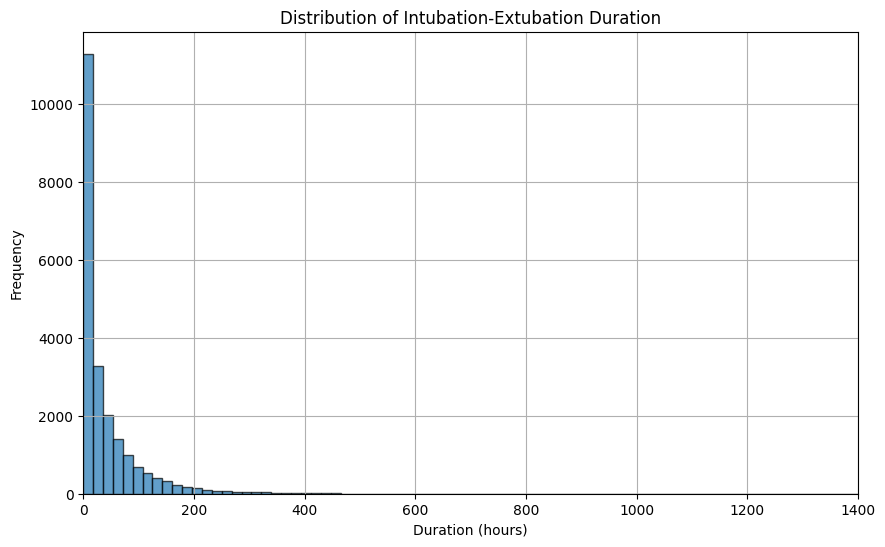

count    21961.000000
mean        40.923597
std         84.762024
min          0.000000
25%          5.250000
50%         16.483333
75%         52.000000
max       8944.000000
Name: duration, dtype: float64

In [52]:
# 삽관 기간의 분포 시각화
subjectlist2_unable.loc[:,'duration'] = (subjectlist2_unable.extubationtime - subjectlist2_unable.intubationtime).dt.total_seconds() / 3600

plt.figure(figsize=(10, 6))
subjectlist2_unable.duration.hist(bins = 500, edgecolor='k', alpha=0.7)
plt.title('Distribution of Intubation-Extubation Duration')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.xlim([0,1400])
plt.show()

subjectlist2_unable.duration.describe()

In [53]:
# 데이터 저장
sub2list_unable = subjectlist2_unable >> select('subject_id','hadm_id',\
                                  'stay_id', 'admittime', 'dischtime')
sub2list_unable = sub2list_unable.drop_duplicates(subset='stay_id')   # remove dup

subjectlist2_unable.to_csv('./data/intubation_extubation_after_reconstruction.csv') 
sub2list_unable.to_csv('./data/sub2list_unable.csv')   # 고유 환자리스트